In [1]:
import pandas as pd
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings            
warnings.filterwarnings("ignore")

In [35]:
df = pd.read_csv('all_train.csv')

In [11]:
# id0 = df[df['userID']==0]
# id1 = df[df['userID']==1]
# id2 = df[df['userID']==2]

# student = pd.concat([id0,id1,id2])
# student

,Unnamed: 0,Unnamed: 0.1,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,index,user_correct_answer,...,test_tag_cumsum,userID-solve_time-mean,userID-solve_time-std,userID-solve_time-skew,test_level_diff_itemID,test_level_diff_KnowledgeTag,test_level_diff_testId,rank_point,test_level,item_ans_Rate
0,0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0.0,...,3.0,46.773103,132.415930,12.619452,0.384,0.400000,0.378667,1000.0,6.984,0.984
1,1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,...,6.0,46.773103,132.415930,12.619452,0.376,0.400533,0.378667,1000.0,6.968,0.968
2,2,2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2,2.0,...,14.0,46.773103,132.415930,12.619452,0.376,0.400533,0.378667,1000.0,6.916,0.916
3,3,3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3,3.0,...,21.0,46.773103,132.415930,12.619452,0.392,0.400533,0.378667,1000.0,6.972,0.972
4,4,4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4,4.0,...,28.0,46.773103,132.415930,12.619452,0.376,0.400533,0.378667,1000.0,6.948,0.948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,1949,1949,2,A050139003,A050000139,0,2020-10-20 11:32:17,428,1949,169.0,...,48.5,60.130435,138.101317,10.905370,0.232,0.280598,0.200000,803.0,5.832,0.832
1950,1950,1950,2,A050139004,A050000139,0,2020-10-20 11:32:18,428,1950,169.0,...,49.5,60.130435,138.101317,10.905370,0.216,0.280598,0.200000,799.0,5.664,0.664
1951,1951,1951,2,A050139005,A050000139,0,2020-10-20 11:32:19,428,1951,169.0,...,50.5,60.130435,138.101317,10.905370,0.176,0.280598,0.200000,796.0,5.464,0.464
1952,1952,1952,2,A050139006,A050000139,0,2020-10-20 11:32:20,428,1952,169.0,...,51.5,60.130435,138.101317,10.905370,0.240,0.280598,0.200000,792.0,5.708,0.708


In [79]:
def serve(df, id, start, stop):
    id = 0
    start = start
    stop = stop
    
    df['date'] = df['Timestamp'].str.slice(start=0, stop=10)
    df['date'] = df['date'].astype('datetime64')

    data = df[(df['userID'] == id) & (df['date']>=start) & (df['date']<=stop)]
    
    # 해당 기간 동안의 정답률
    test_data = data.groupby(['testId','test_ans_rate']).tail(1)
    test_plot = test_data.loc[:,['testId','test_ans_rate']]  # test 최종 정답률
    
    # 해당 기간 동안의 tag 정답률 (마지막 시험지의 tag 누적 정답률)
    # 마지막 시험지 찾아오고 tag별 정답률
    last_test = data.tail(1)['testId'].values[0]
    tag_data = data[data['testId'] == last_test].loc[:,['testId','KnowledgeTag','tag_ans_rate']]
    tag_plot = tag_data.groupby(['KnowledgeTag']).tail(1)
    
    return test_plot, last_test, tag_plot

In [80]:
id = 0
start = '2020-03-24'
stop = '2020-03-24'
test_plot, last_test, tag_plot = serve(df, id, start, stop)

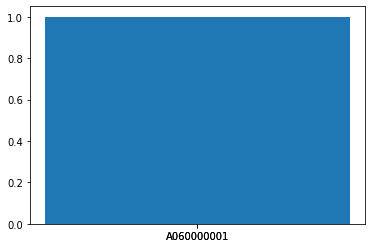

In [81]:
x = list(test_plot['testId'].values)
y = list(test_plot['test_ans_rate'].values)


plt.bar(x,y)
plt.xticks(x)
plt.savefig('plt1.png')

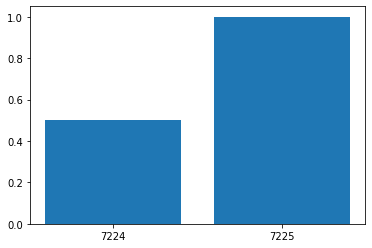

In [82]:
x = list(tag_plot['KnowledgeTag'].values)
y = list(tag_plot['tag_ans_rate'].values)

plt.bar(x,y)
plt.xticks(x)
plt.savefig('plt2.png')